In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai import *
from fastai.vision import *
import pandas as pd
import numpy as np

In [4]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/planet')

In [6]:
! kaggle datasets download nikitarom/planets-dataset -p "{path}"
! unzip -q -n '{path}'/planets-dataset.zip -d '/content/file' 

100% 1.50G/1.50G [00:07<00:00, 129MB/s]
100% 1.50G/1.50G [00:07<00:00, 209MB/s]


In [7]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [8]:
np.random.seed(42)
src = (ImageList.from_csv(path='/content/file/planet/planet', csv_name='train_classes.csv', folder='train-jpg', suffix='.jpg')
      .split_by_rand_pct(0.2)
      .label_from_df(label_delim=' '))

In [9]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

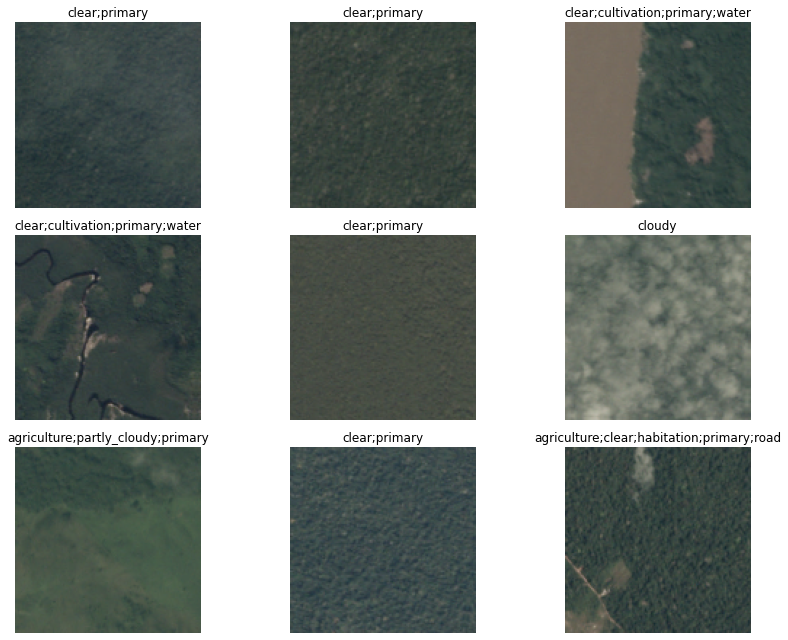

In [10]:
data.show_batch(rows=3, figsize=(12, 9))

In [11]:
arch = models.resnet50

In [12]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
model = cnn_learner(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [13]:
model.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


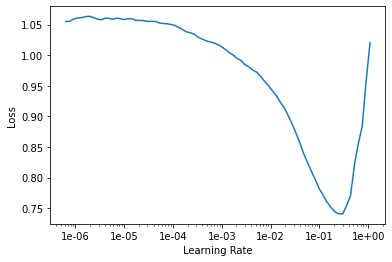

In [14]:
model.recorder.plot()

In [15]:
lr = 0.01

In [16]:
model.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.137752,0.115378,0.944090,0.899994,02:42
1,0.114709,0.098198,0.951502,0.916041,02:42
2,0.104676,0.093292,0.953559,0.920436,02:43
3,0.095005,0.088471,0.954474,0.923634,02:43
4,0.092077,0.087284,0.957461,0.925154,02:43


In [17]:
model.save('stage-1')

In [18]:
model.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


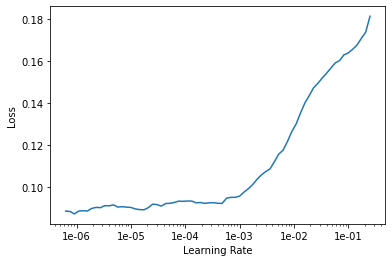

In [19]:
model.lr_find()
model.recorder.plot()

In [20]:
model.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.097848,0.092375,0.954888,0.920358,02:53
1,0.095950,0.092036,0.955746,0.921245,02:52
2,0.089206,0.086025,0.956633,0.926448,02:52
3,0.083848,0.083278,0.959416,0.928433,02:52
4,0.078424,0.082207,0.959067,0.929657,02:52


In [21]:
model.save('stage-2')

In [22]:
data2 = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

model.data = data2
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [23]:
model.freeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


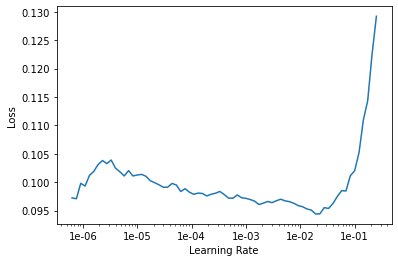

In [24]:
model.lr_find()
model.recorder.plot()

In [25]:
lr2 = 1e-2/2

In [26]:
model.fit_one_cycle(5, slice(lr2))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.086754,0.086121,0.957011,0.925712,05:43
1,0.090299,0.083348,0.959917,0.928603,05:44
2,0.082234,0.082668,0.956516,0.928018,05:44
3,0.082248,0.080884,0.958129,0.930942,05:44
4,0.079867,0.081115,0.959132,0.930555,05:45


In [27]:
model.save('stage-1-256')

In [28]:
model.unfreeze()

In [29]:
model.fit_one_cycle(5, slice(1e-5, lr2/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.084636,0.084267,0.956923,0.927439,07:10
1,0.084844,0.083841,0.958456,0.927356,07:09
2,0.085512,0.081798,0.957308,0.929400,07:09
3,0.079758,0.080572,0.959292,0.930724,07:09
4,0.074914,0.080392,0.959743,0.931062,07:09


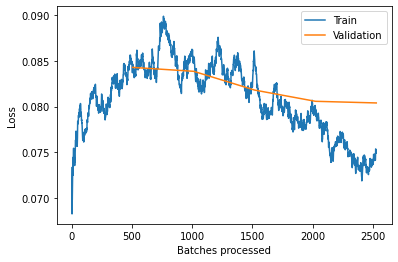

In [30]:
model.recorder.plot_losses()

In [31]:
model.save('stage-2-256')